<h1 dir="rtl" style="color:red;text-align:center">
محمد علی قهاری CA3 - 810100201
</h1>
<h3 dir="rtl" style="color:cyan;text-align:right">
سوال 1 : چون ما از ماتریس ها در محاسبات خود استفاده میکنیم(برای افزایش سرعت) بنابر این باید طول ورودی شان یکی باشد وگرنه ارور میدهد.
<br><br>
سوال 2 : در MFCC فریم ها مثل یک پنجره هستند که ممکن است چند فریم باشند. در غیر این صورت اتفاقات لب مرزی بین دو فریم دچار خدشه میشوند!
<br><br>
سوال 3 : در MFCC 13 ضریب ابتدایی نشان دهنده پوشش طیفی صدا هستند و ضرایب بعد از آن نشان دهنده جزئیات طیفی آن صدا هستند که برای فرق گذاشتن بین صدا ها همان 13 تا کافی هستند و ما الکی نمیآییم محاسبات را سنگین تر کنیم.
</h3>

In [102]:
import numpy as np
import hmmlearn.hmm as hmm
import os
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from scipy.stats import multivariate_normal as normal
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
from tabulate import tabulate

In [113]:
genre_list = ["blues","hiphop","metal","pop"]
HIDDEN_STATES = 4
ITERATIONS = 12

In [115]:
def feature_extraction(file):
    y, sr = librosa.load(file)
    coefs  = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)
    return coefs[:,:1290]

def feature_extraction2(file):
    sampling_freq, audio = wav.read(file)
    return mfcc(audio, sampling_freq ,nfft=1024)[:2900,:]

def confusion_matrix(predictions):
    c_matrix = [[0] * len(genre_list) for _ in range(len(genre_list))]
    for pred in predictions:
        y_pred, y_real = pred
        for i, s_i in enumerate(genre_list):
            if s_i == y_real:
                for j, s_j in enumerate(genre_list):
                    if s_j == y_pred:
                        c_matrix[i][j] += 1
    return c_matrix

def evaluate(models, is_library):  
    acc = 0
    results = []
    for file in os.listdir("test"):
        coefs = feature_extraction2("test/" + file)
        max_score = -np.Infinity
        res = ''
        for label in genre_list:
            score = models[label].score(coefs) if is_library else models[label].score(coefs.T/np.amax(coefs.T))
            if score > max_score:
                max_score = score
                res = label
        real = file.split('.')[0]
        results.append((res, real))
        if file.startswith(res):
            acc += 1 

    c_matrix = confusion_matrix(results)
    plt.figure(figsize=(8, 6))
    sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=genre_list, yticklabels=genre_list)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    style_result = dict()
    for genre in genre_list:
        Tp = 0
        Fp = 0
        Fn = 0
        for res in results:
            pred, real = res
            if pred == genre and real == pred:
                Tp += 1
            elif pred == genre and real != pred:
                Fp += 1
            elif real == genre and pred != real:
                Fn +=1
        style_result[genre] = (Tp, Fp, Fn)

    metrics = ["Precision", "Recall", "F1"]
    class_metrics = [[] for _ in range(len(genre_list))]
    macro_precision = 0
    macro_recall =0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    f1_sum = 0
    for i in range(len(genre_list)):
        tp, fp, fn = style_result[genre_list[i]]
        class_metrics[i].append(genre_list[i])
        class_metrics[i].append(tp / (tp + fp))
        class_metrics[i].append(tp / (tp + fn))
        class_metrics[i].append((2 * class_metrics[i][1] * class_metrics[i][2]) / (class_metrics[i][1] + class_metrics[i][2]))
        macro_precision += class_metrics[i][1]
        macro_recall += class_metrics[i][2]
        tp_sum += tp
        fp_sum += fp
        fn_sum += fn
        f1_sum += class_metrics[i][3]

    print(tabulate(class_metrics, metrics, tablefmt='fancy_grid'))
    print(f"total accuracy: {acc/len(os.listdir('test'))}")
    print(f"micro precision: {tp_sum/(tp_sum + fp_sum)} micro recall: {tp_sum/(tp_sum+fn_sum)}")
    print(f"macro precision: {macro_precision/len(genre_list)} macro recall: {macro_recall/len(genre_list)}")
    print(f"average F1: {f1_sum/len(genre_list)}")

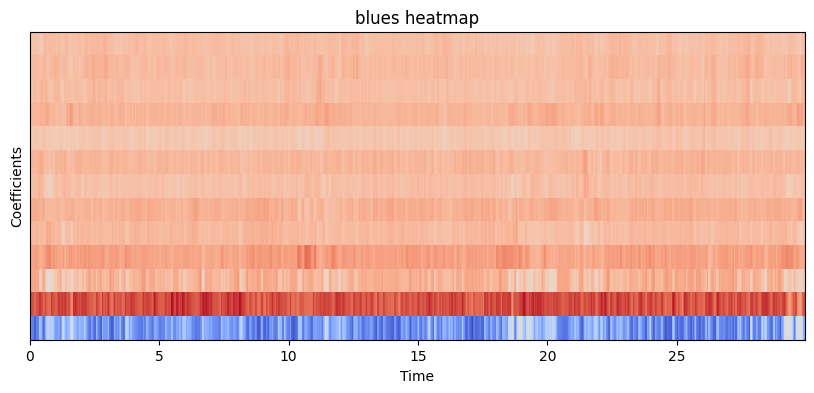

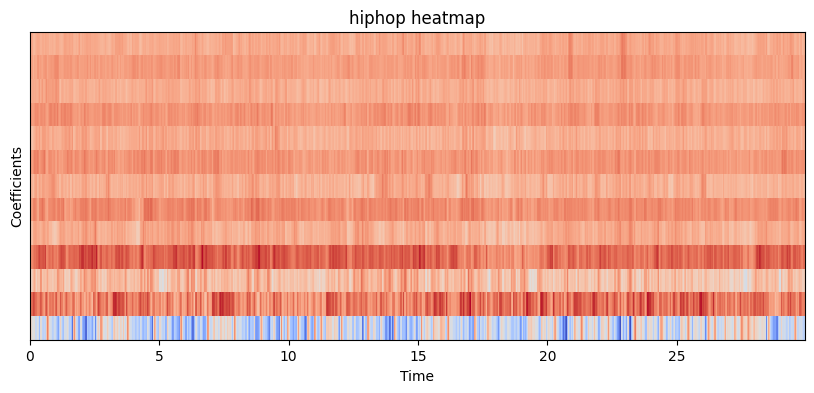

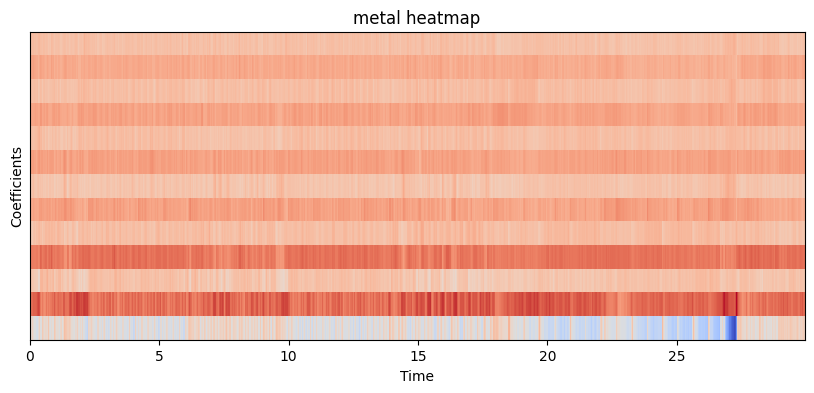

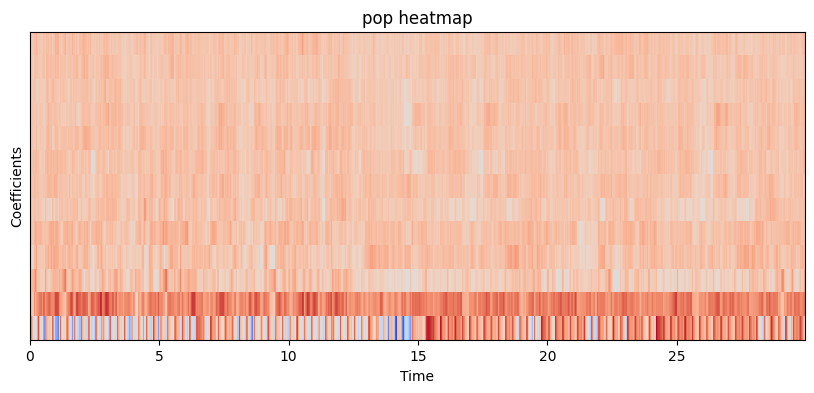

In [105]:
for genre in genre_list:
   plt.figure(figsize=(10, 4))
   librosa.display.specshow(feature_extraction(genre + "/" + genre + ".00020.wav"), x_axis='time')
   plt.title(genre + ' heatmap')
   plt.ylabel('Coefficients')
   plt.show()

<h3 dir="rtl" style="color:cyan;text-align:right">
سوال 1 : استیت ها در این مساله یک موجودات مخفی هستند!
احتمال رفتن از هر استیت به دیگری در transition matrix ذخیره میشود.<br>
Observation ها همان فیچر هایی است که از فایل های صوتی میخوانیم که در اینجا ما MFCC را انتخاب میکنیم که هر فایل به تعداد فریم هایش به ما Observation میدهد که هر کدام 13 ضریب دارند. که ما باید توزیع این ضرایب را به دست آوریم برای هر ژانر.<br>
هدف مساله فهمیدن استیت فعلی ما نیست بلکه میزان فیت بودن یک دنباله از ضرایب با مدل آموزش دیده ما است!
<br><br>
سوال 2 : این مساله به این دلیل مرتبه اول است چون هر استیت مخفی به یک Observation متصل است و هر استیت به استیت قبلی خود وابسته است!<br>
این مدل ساده است و محاسبات سبکی دارد که برای اکثر مواقع خوب عمل میکند مگر اینکه روابط بین استیت ها واقعا پیچیده باشد که باید از مدل های با مرتبه بالا تر استفاده کنیم!
<br><br>
سوال 3 : HMM برای مسالی که دارای داده های پشت سر هم هستند (زمان در آن ها مطرح است)مثل (audio analysis, handwriting recognition) کاربرد دارد!
<br><br>
سوال 4: <br>
مزایا : <br>
HMM قابلیت انعطاف بالایی دارد که باعث میشود در اکثر مسائل موثر باشد. همچنین فهم و درک آن راحت تر است و مثل neutal network سخت فهم نیست.
میتوان به کم هزینه بودن محاسبات آن نیز اشاره داشت!
<br>
معایب : <br>
اول از همه این مدل نیاز به مقدار قابل توجهی دیتای درست میباشد تا آموزش ببیند.
همچنین HMM برای دیتا های پیچیده دارا محدودیت است. 
علاوه بر آن پارامتر های اولیه آن در جواب نهایی آن تاثیر میگذارند (که در اکثر مدل ها این اتفاق می افتد!)
<br><br>
سوال 5 : برای مثال hierarchical HMM وجود دارد که برای جا هایی استفاده میشود که یک سلسله مراتبی بین داده ها وجود دارد و هر استیت یک بخشی از آن را دارد.
<br> High level HMM  هم یک مدل دیگر است که برای فیچر های پیچیده استفاده میشود.
</h3>

In [106]:
models = {}
for directory in genre_list:
    x = np.array([])
    for file in os.listdir(directory):
        coefs = feature_extraction2(directory + "/" + file)
        if len(x) == 0:
            x = coefs
        else:
            x = np.append(x, coefs, axis = 0)
    model = hmm.GaussianHMM(n_components=HIDDEN_STATES, covariance_type='diag', n_iter=ITERATIONS)
    print("training " + directory)
    model.fit(x)
    print("train end!")
    models[directory] = model

training blues
train end!
training hiphop
train end!
training metal
train end!
training pop
train end!


╒════════╤═════════════╤══════════╤══════════╕
│        │   Precision │   Recall │       F1 │
╞════════╪═════════════╪══════════╪══════════╡
│ blues  │    0.714286 │     1    │ 0.833333 │
├────────┼─────────────┼──────────┼──────────┤
│ hiphop │    0.428571 │     0.45 │ 0.439024 │
├────────┼─────────────┼──────────┼──────────┤
│ metal  │    0.823529 │     0.7  │ 0.756757 │
├────────┼─────────────┼──────────┼──────────┤
│ pop    │    0.928571 │     0.65 │ 0.764706 │
╘════════╧═════════════╧══════════╧══════════╛
total accuracy: 0.7
micro precision: 0.7 micro recall: 0.7
macro precision: 0.7237394957983193 macro recall: 0.7
average F1: 0.6984550906717334


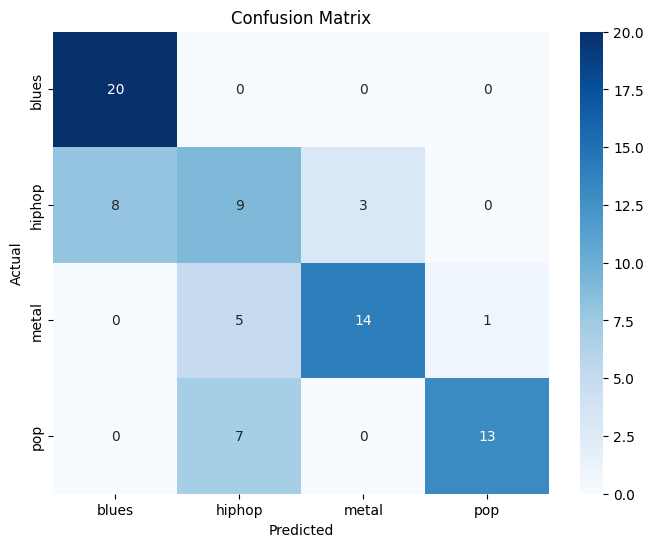

In [116]:
evaluate(models, True)

In [118]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:, t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = normal.pdf(obs.T, mean=self.mean[:,s], cov=self.covariances[:,:,s])

        return B

    def _normalize(self, x)->list:
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x:list)->list:
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [119]:
models2 = {}
for directory in genre_list:
    x = np.array([])
    for file in os.listdir(directory):
        coefs = feature_extraction2(directory + "/" + file)
        if len(x) == 0:
            x = coefs
        else:
            x = np.append(x, coefs, axis = 0)
    model = HMM(HIDDEN_STATES)
    print("training start " + directory)
    model.train(x.T / np.amax(x.T), ITERATIONS) # 
    print("training end " + directory)
    models2[directory] = model

training start blues
training end blues
training start hiphop
training end hiphop
training start metal
training end metal
training start pop
training end pop


╒════════╤═════════════╤══════════╤══════════╕
│        │   Precision │   Recall │       F1 │
╞════════╪═════════════╪══════════╪══════════╡
│ blues  │    0.904762 │     0.95 │ 0.926829 │
├────────┼─────────────┼──────────┼──────────┤
│ hiphop │    0.2      │     0.1  │ 0.133333 │
├────────┼─────────────┼──────────┼──────────┤
│ metal  │    0.46875  │     0.75 │ 0.576923 │
├────────┼─────────────┼──────────┼──────────┤
│ pop    │    1        │     0.85 │ 0.918919 │
╘════════╧═════════════╧══════════╧══════════╛
total accuracy: 0.6625
micro precision: 0.6625 micro recall: 0.6625
macro precision: 0.6433779761904762 macro recall: 0.6625
average F1: 0.6390011493670029


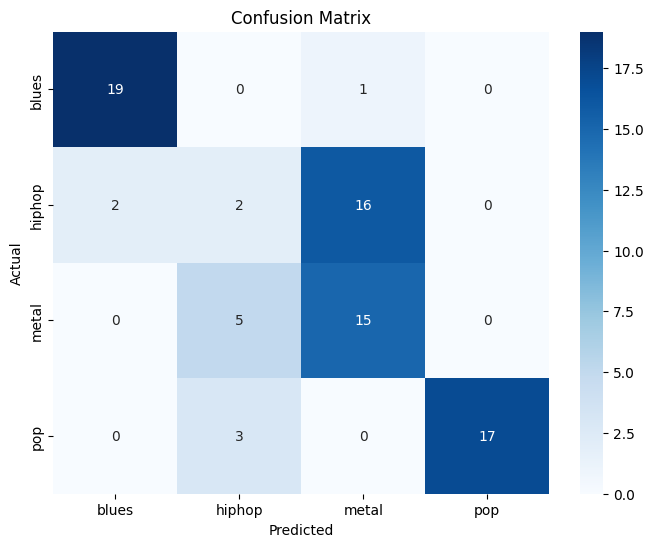

In [120]:
evaluate(models2, False)

$Accuracy = \frac{True Predictions}{All Predictions}$

$Precision = \frac{True Positive}{True Positive + False Positive}$

$Recall = \frac{True Positive}{True Positive + False Negative}$

$F1  = 2* \frac{Recall * Precision}{Recall + Precision}$

<h2 dir="rtl" style="text-align:right">
سوال 1 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
برای محاسبه Accuracy باید تعداد تشخیص های درست را به کل تقسیم کنیم که به درصد نمایش داده میشود!
<br>
Accuracy در کلاس بندی به تنهایی مشکل گشا نیست چون اگر ما چند کلاس کوچک داشته باشیم و مدل ما برای آن به درستی تصمیم نمیگیرد و لی برای کلاس های بزرگ(یعنی تعدادشان در تست کیس زیاد است) درست تصمیم میگیرد، Accuracy میگوید مدل دقیق است اما از نظر ما دقیق نیست!
<br><br>
Precision برای یک کلاس خاص یعنی تعداد حدس های درست مدل ما از آن کلاس به کل آن هایی که گفته از این کلاس هستند(یعنی گفته از کلاس A هست در حالی که نیست! + آن هایی که گفته هست و واقعا هست.)
<br><br>
Recall هم یعنی تعداد حدس های درست از یک کلاس به کل تعداد آن کلاس.
<br><br>
F1 هم یک فاکتور بالانس شده بین Recall , Precision است. که پرفورمنس مدل را ارائه میدهد و بین 0 و 1 است!
</h4>

<h2 dir="rtl" style="text-align:right">
سوال 2 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
تفاوت فرمولی که در بالا گفته شد! 
دلیل بدون فایده بودن هر کدام به تنهایی هم در این مثال معلوم میشود.<br>
فرض کنید 10 داده داریم که 5 تا درست است و 5 تا شان غلط.<br>
حال مدل ما هر 10 تا را درست حدس زده که طبق فرمول ها Recall میشود 1 اما مدل ما نصف را غلط گفته (Precision = .5)<br>
حال فرض کنید که مدل ما فقط یکی از درست ها را بگوید درست و باقی را بگوید غلط، بنابر این Precision = 1 که بازهم معیار خوبی به تنهایی نیست (Recall = .2)
</h4>

<h2 dir="rtl" style="text-align:right">
سوال 3 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
F1 یک نوع میانگین گیری هارمونیک است که نسبت به داده های نویزی کمتر واکنش نشان میدهد.<br>
این نوع میانگین گیری به ویژه در مجوعه داده های نا متوازن استفاده میشود. چون همانطور که میبینید تفاوت های فاحشی میتواند بین Reacll , Precision باشد!
</h4>

<h2 dir="rtl" style="text-align:right">
سوال 4 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
micro تمام Tp, Fp, Fn ها را روی تمام کلاس ها حساب میکند و بعد یک Precision یا Recall کلی روی کل داده ها میدهد.<br>
macro بین Precision یا Recall های محاسبه شده میانگین میگیرد<br>
weighted همان ماکرو است منتها به بعضی از کلاس ها ضریب بیشتری میدهد(دارای ضریب است!)<br>
در واقع micro روی نمونه ها میانگین میگیرد ولی macro , weighted  روی کلاس ها!
</h4>

<h2 dir="rtl" style="text-align:right">
سوال 6 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
مدل کتابخانه برای  ژانر hiphop خوب عمل نمیکند و آن را با blues اشتباه میگیرد، همچنین برخی از pop هارا hip hop میگیرد که شاید به دلیل شباهت های mfcc شان است!<br>
همچنین مدل ما hiphop را با metal کلا قاطی کرده که نشان دهنده زیبایی علم است:) احتمالا دیتا های آموزششان شبیه هم بوده.<br>
البته مدل ما از مدل کتابخانه ای بد تر است که در پایین توضیح داده شده!
</h4>

<h2 dir="rtl" style="text-align:right">
سوال 7 :
</h2>
<h4 dir="rtl" style="color:cyan;text-align:right">
مدل آماده احتمالا یک سری پارامتر های اضافه تر درون خود به مساله اضافه کرده که باعث بهتر شدن نتیجه شده.<br>
مهمترین نکته این است که چگونه observation ها را روی ماتریس B (که همان احتمال یک observe در یک استیت است) ست میکند!
</h4>